720 No of points in given sample
8000 Sampling Freq


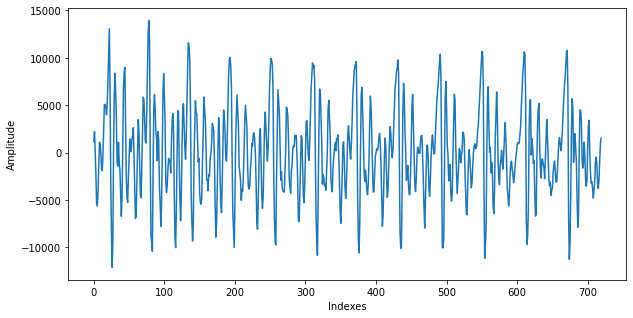

In [18]:
import scipy 
from scipy import signal
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
import numpy as np 
import math
from scipy.fft import fft
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels
file = scipy.io.wavfile.read('aa.wav')
inp = file[1]
length = len(file[1])
print(len(inp), "No of points in given sample")
print(file[0],"Sampling Freq")
plt.figure(figsize=(10, 5))
plt.xlabel('Indexes')
plt.ylabel('Amplitude')
plt.plot(inp)

720


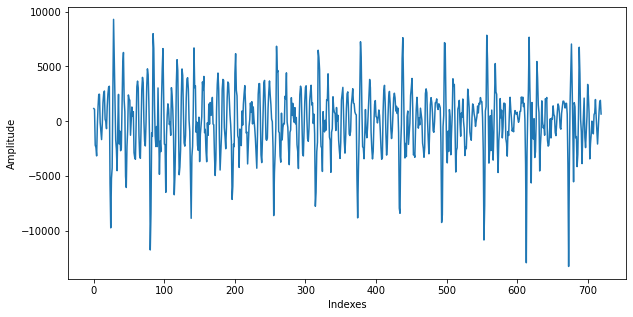

In [19]:
# Premphasis of the signal
y=[]
alpha = 0.96
y.append(inp[0])
for i in range(1,length):
	y.append(inp[i] - alpha*inp[i-1])
print(len(y))
plt.figure(figsize=(10, 5))
plt.xlabel('Indexes')
plt.ylabel('Amplitude')
plt.plot(y)

/Users/adityakhanna/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


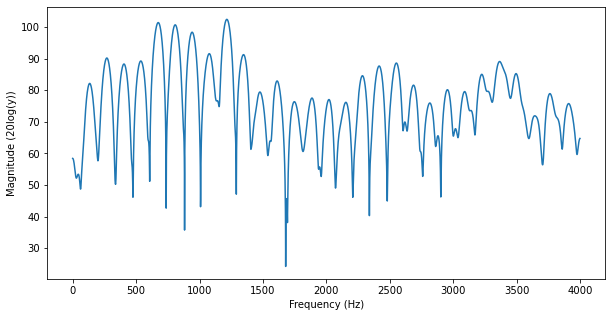

In [20]:
# Narrowband Magnitude Spectrum Slice (0 to 4000 Hz)
Window_length = 0.03 
F_s = 8000
y_new = (y[240:480]) * np.hamming(int(Window_length*F_s)) # Middle of 0,720 is is 240:480
dft = np.fft.fft(y_new, F_s)
x_axis = np.arange(0, F_s/2 , 1)
plt.figure(figsize=(10, 5))
plt.plot(20*np.log10(dft[:int(F_s/2)]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (20log(y))')
plt.show()

In [21]:
def acc(inp,k):
    sum=0
    y_new = inp * np.hamming(int(len(inp)))
    for i in range(len(inp)-k):
        sum+=y_new[i]*y_new[i+k]
    return sum;

In [22]:
print("Coefficient for 2",acc(y[240:480],2))
print("Coefficient for 4",acc(y[240:480],4))
print("Coefficient for 6",acc(y[240:480],6))
print("Coefficient for 8",acc(y[240:480],8))
print("Coefficient for 10",acc(y[240:480],10))

Coefficient for 2 67285038.76564053
Coefficient for 4 -440452087.8947213
Coefficient for 6 -106421839.14026347
Coefficient for 8 52466426.938704595
Coefficient for 10 37078435.998169534


In [23]:
#levinsondurbin recursion

def levinsondurbin(inp,p):
    a=[]
    e=[]
    E_0=acc(inp,0)
    k_1= acc(inp,1)/E_0
    a.append([k_1])
    e.append((1-k_1*k_1)*E_0)
    for i in range(2,p+1):
        r_i=acc(inp,i)
        sum=0
        for j in range(1,i):
            sum+=a[i-2][j-1]*acc(inp,i-j)
        k_i=(r_i - sum)/ e[i-2]
        rand=[]
        for j in range(1,i):
            rand.append(a[i-2][j-1] - k_i * a[i-2][i-j-1])
        rand.append(k_i)
        a.append(rand)
        e.append((1 - k_i*k_i)*e[i-2])
    return a,e

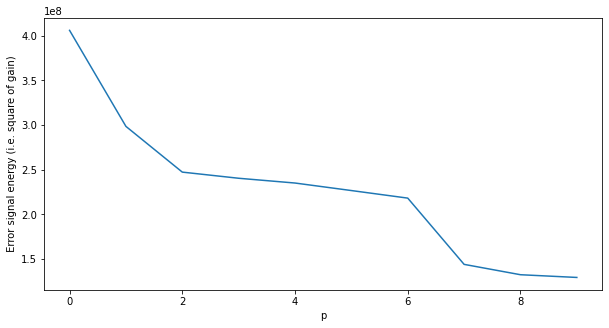

405924200.6811512
298455523.92881083
247275552.80917126
240396134.87321654
235057524.88532895
226642061.9813689
218173286.28775835
144032415.2495521
132441465.05211775
129393101.04580607


In [24]:
# a_2,e_2= levinsondurbin(y[240:480],2)
# a_4,e_4= levinsondurbin(y[240:480],4)
# a_6,e_6= levinsondurbin(y[240:480],6)
# a_8,e_8= levinsondurbin(y[240:480],8)
a_10,e_10= levinsondurbin(y[240:480],10)
plt.figure(figsize=(10, 5))
plt.plot(e_10)
plt.xlabel('p')
plt.ylabel(' Error signal energy (i.e. square of gain) ')
plt.show()


for i in e_10:
    print(i)

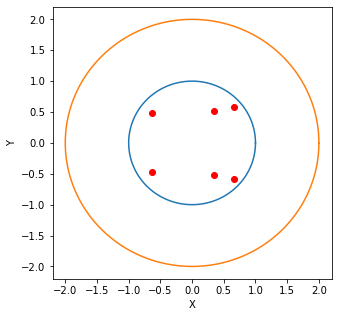

[-0.63759918+0.47891702j -0.63759918-0.47891702j  0.66020911+0.58275343j
  0.66020911-0.58275343j  0.34468897+0.51467932j  0.34468897-0.51467932j]


In [25]:
# Poles for p=6 

aa=[1]
for i in a_10[5]:
    aa.append(-1* i)
poles_6 = np.roots(aa)
X = [x.real for x in poles_6]
Y = [x.imag for x in poles_6]
r0=1
r1=2
plt.figure(figsize=(5, 5))
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X,Y, color='red')
theta = np.arange(0, np.pi*2, 0.01)
plt.plot(r0 * np.cos(theta), r0 * np.sin(theta))
plt.plot(r1 * np.cos(theta), r1 * np.sin(theta))
plt.show()
print(poles_6)

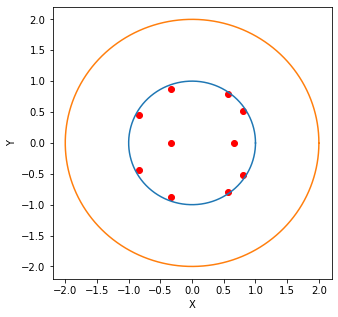

[ 0.56126798+0.78974885j  0.56126798-0.78974885j  0.80442425+0.52220414j
  0.80442425-0.52220414j  0.65854654+0.j         -0.33552343+0.87503661j
 -0.33552343-0.87503661j -0.83641676+0.44518892j -0.83641676-0.44518892j
 -0.33838162+0.j        ]


In [26]:
# Poles for p=10
aaa=[1]
for i in a_10[9]:
    aaa.append(-1* i)
poles_10 = np.roots(aaa)
X = [x.real for x in poles_10]
Y = [x.imag for x in poles_10]
r0=1
r1=2
plt.figure(figsize=(5, 5))
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X,Y, color='red')
theta = np.arange(0, np.pi*2, 0.01)
plt.plot(r0 * np.cos(theta), r0 * np.sin(theta))
plt.plot(r1 * np.cos(theta), r1 * np.sin(theta))
plt.show()
print(poles_10)

In [32]:
def LPC_spectrum(p):
    rand=[1]
    for i in a_10[p-1]:
        rand.append(-1* i)
    den = rand
    num = math.sqrt(e_10[p-1])
    w, h = scipy.signal.freqz(num, den)
    plt.plot(w*4000/3.14, 20*np.log10(abs(h)), label='p=' + str(p))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude in (dB)')

/Users/adityakhanna/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


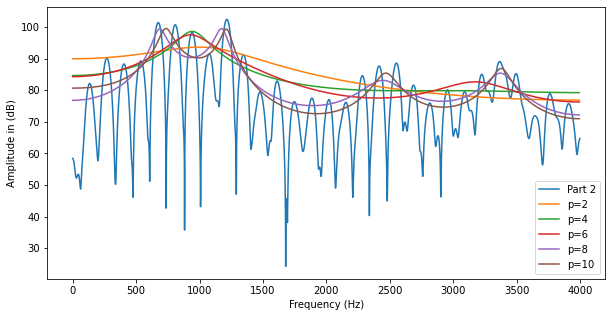

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(20*np.log10(dft[:int(F_s/2)]),label= "Part 2")
LPC_spectrum(2)
LPC_spectrum(4)
LPC_spectrum(6)
LPC_spectrum(8)
LPC_spectrum(10)
plt.legend()
plt.show()

No handles with labels found to put in legend.


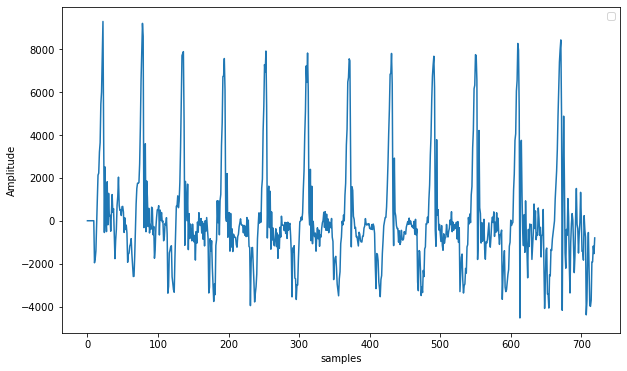

In [29]:
error= []
for i in range(0,10):
    error.append(0)
for i in range(10,720):
    error.append(inp[i])
    for j in range(1,11):
        error[i]-=a_10[9][j-1]*inp[i-j]
plt.figure(figsize=(10,6))
plt.plot(error)
plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

NameError: name 'plot' is not defined

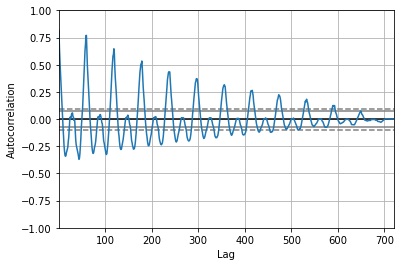

In [30]:
x = pd.plotting.autocorrelation_plot(error)
plot(x)

NameError: name 'plot' is not defined

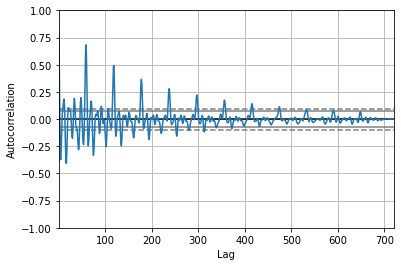

In [31]:
x = pd.plotting.autocorrelation_plot(inp/np.amax(inp))
plot(x)